https://github.com/ddangelov/Top2Vec/blob/master/notebooks/CORD-19_top2vec.ipynb

In [1]:
import numpy as np 
import pandas as pd 
import json
import os
import ipywidgets as widgets
from IPython.display import clear_output, display
from top2vec import Top2Vec

In [12]:
metadata_df = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/COVID-19_data/metadata.csv")
metadata_df.shape

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4,5,6,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(315948, 19)

In [13]:
metadata_df = metadata_df[0:1000]

In [14]:
metadata_df.shape

(1000, 19)

In [24]:
def preproccess_papers():

    dataset_dir = "/Users/sdeshpande/Desktop/bioinformatices/COVID-19_data/document_parses/"
    pdf_dir = dataset_dir+"pdf_json/"
    pmc_dir = dataset_dir+"pmc_json/"
    directories_to_process = [pdf_dir,pmc_dir]

    papers_with_text = list(metadata_df.sha)

    paper_ids = []
    titles = []
    abstracts = []
    sections = []
    body_texts = []

    for directory in directories_to_process:

        filenames = os.listdir(directory)

        for filename in filenames:

            file = json.load(open(directory+filename, 'rb'))

          #check if file contains text
            if file["paper_id"] in papers_with_text:

                section = []
                text = []

                for bod in file["body_text"]:
                    section.append(bod["section"])
                    text.append(bod["text"])

                res_df = pd.DataFrame({"section":section, "text":text}).groupby("section")["text"].apply(' '.join).reset_index()

                for index, row in res_df.iterrows():

                  # metadata
                    paper_ids.append(file["paper_id"])

                    if(len(file["abstract"])):
                        abstracts.append(file["abstract"][0]["text"])
                    else:
                        abstracts.append("")

                    titles.append(file["metadata"]["title"])

                  # add section and text
                    sections.append(row.section)
                    body_texts.append(row.text)

    return pd.DataFrame({"id":paper_ids, "title": titles, "abstract": abstracts, "section": sections, "text": body_texts})

In [25]:
papers_df = preproccess_papers()
papers_df.head()

,id,title,abstract,section,text
0,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Case Report,A 35 year old South Indian male presented to t...
1,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Conclusion,Patients with severe community acquired pneumo...
2,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Consent,Written informed consent was obtained from the...
3,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Discussion of the Case,Methicillin resistant Staphylococcus aureus (M...
4,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Introduction,CA-MRSA commonly causes skin and soft tissue i...


In [26]:
def filter_short(papers_df):
    papers_df["token_counts"] = papers_df["text"].str.split().map(len)
    papers_df = papers_df[papers_df.token_counts>200].reset_index(drop=True)
    papers_df.drop('token_counts', axis=1, inplace=True)
    
    return papers_df

In [27]:
papers_df = filter_short(papers_df)
papers_df.head()

,id,title,abstract,section,text
0,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Case Report,A 35 year old South Indian male presented to t...
1,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,Community acquired methicillin-resistant Staph...,Community-acquired methicillin resistant Staph...,Discussion of the Case,Methicillin resistant Staphylococcus aureus (M...
2,dff6195f5e24ebfa2fb4060142611b48021f673c,"Virology Journal Neutrophil elastase, an acid-...",Background: Mammalian reoviruses naturally inf...,Analysis of reovirus replication in U937 cells...,Treatment of the promonocytic U937 cells with ...
3,dff6195f5e24ebfa2fb4060142611b48021f673c,"Virology Journal Neutrophil elastase, an acid-...",Background: Mammalian reoviruses naturally inf...,Analysis of viral protein expression in infect...,Cells were plated at 10 6 /well in a 6-well pl...
4,dff6195f5e24ebfa2fb4060142611b48021f673c,"Virology Journal Neutrophil elastase, an acid-...",Background: Mammalian reoviruses naturally inf...,B.,Virion ISVP we first established conditions un...


In [28]:
papers_df.shape

(7161, 5)

# Train Top2Vec Model

In [34]:
top2vec = Top2Vec(documents=papers_df.text, speed="learn", workers=4)

2020-10-24 13:03:51,568 - top2vec - INFO - Pre-processing documents for training
2020-10-24 13:03:59,376 - top2vec - INFO - Creating joint document/word embedding
2020-10-24 13:08:59,489 - top2vec - INFO - Creating lower dimension embedding of documents
2020-10-24 13:09:02,967 - top2vec - INFO - Finding dense areas of documents
2020-10-24 13:09:03,109 - top2vec - INFO - Finding topics


documents: Input corpus, should be a list of strings.

speed: This parameter will determine how fast the model takes to train. The 'fast-learn' option is the fastest and will generate the lowest quality vectors. The 'learn' option will learn better quality vectors but take a longer time to train. The 'deep-learn' option will learn the best quality vectors but will take significant time to train.

workers: The amount of worker threads to be used in training the model. Larger amount will lead to faster training

# 1. Load pre-trained Top2Vec model

In [ ]:
!pip install numpy --upgrade

In [ ]:
#top2vec = Top2Vec.load("../input/covid19top2vec/covid19_deep_learn_top2vec") - Doesn't work

# 2. Load pre-processed papers

In [4]:
!pip install pyarrow

     |████████████████████████████████| 13.4 MB 3.9 MB/s eta 0:00:01


In [ ]:
#papers_df = pd.read_feather("../input/covid19top2vec/covid19_papers_processed.feather")

# 1. Search Topics

Label(value='Enter keywords seperated by space: ')

Text(value='medicine')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of topics: ')

Text(value='5')

Button(description='show topics', style=ButtonStyle())

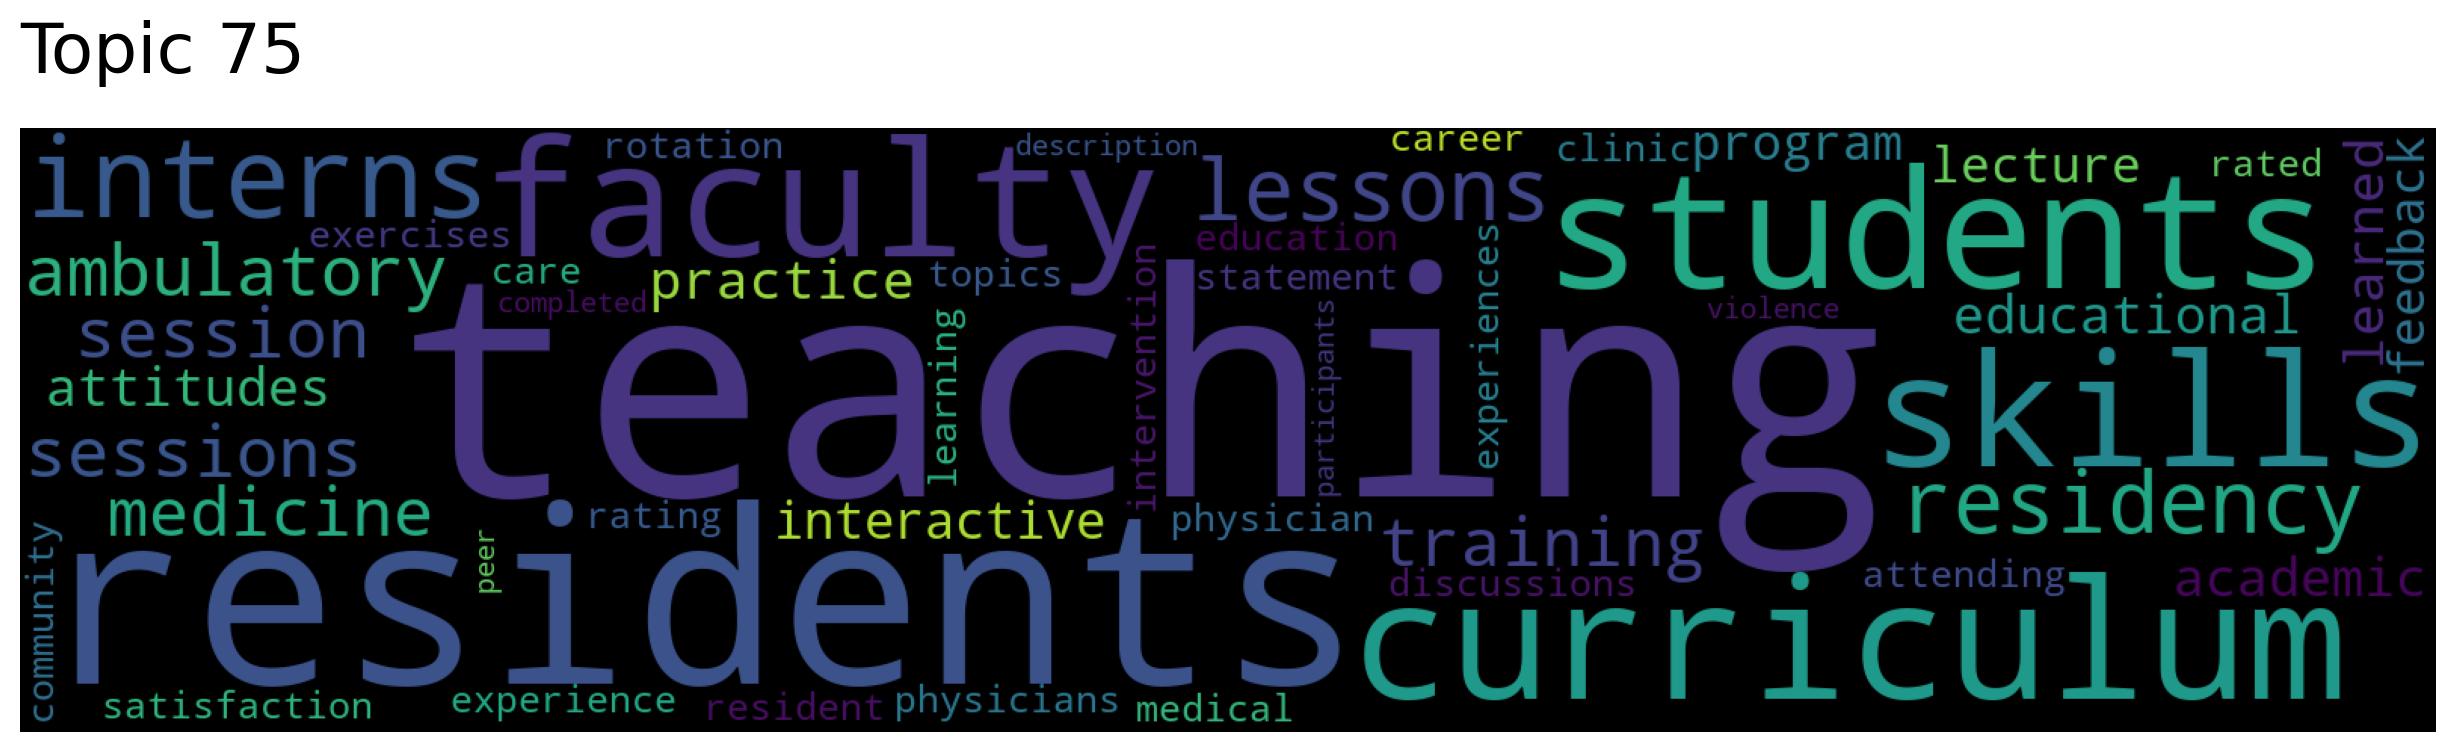

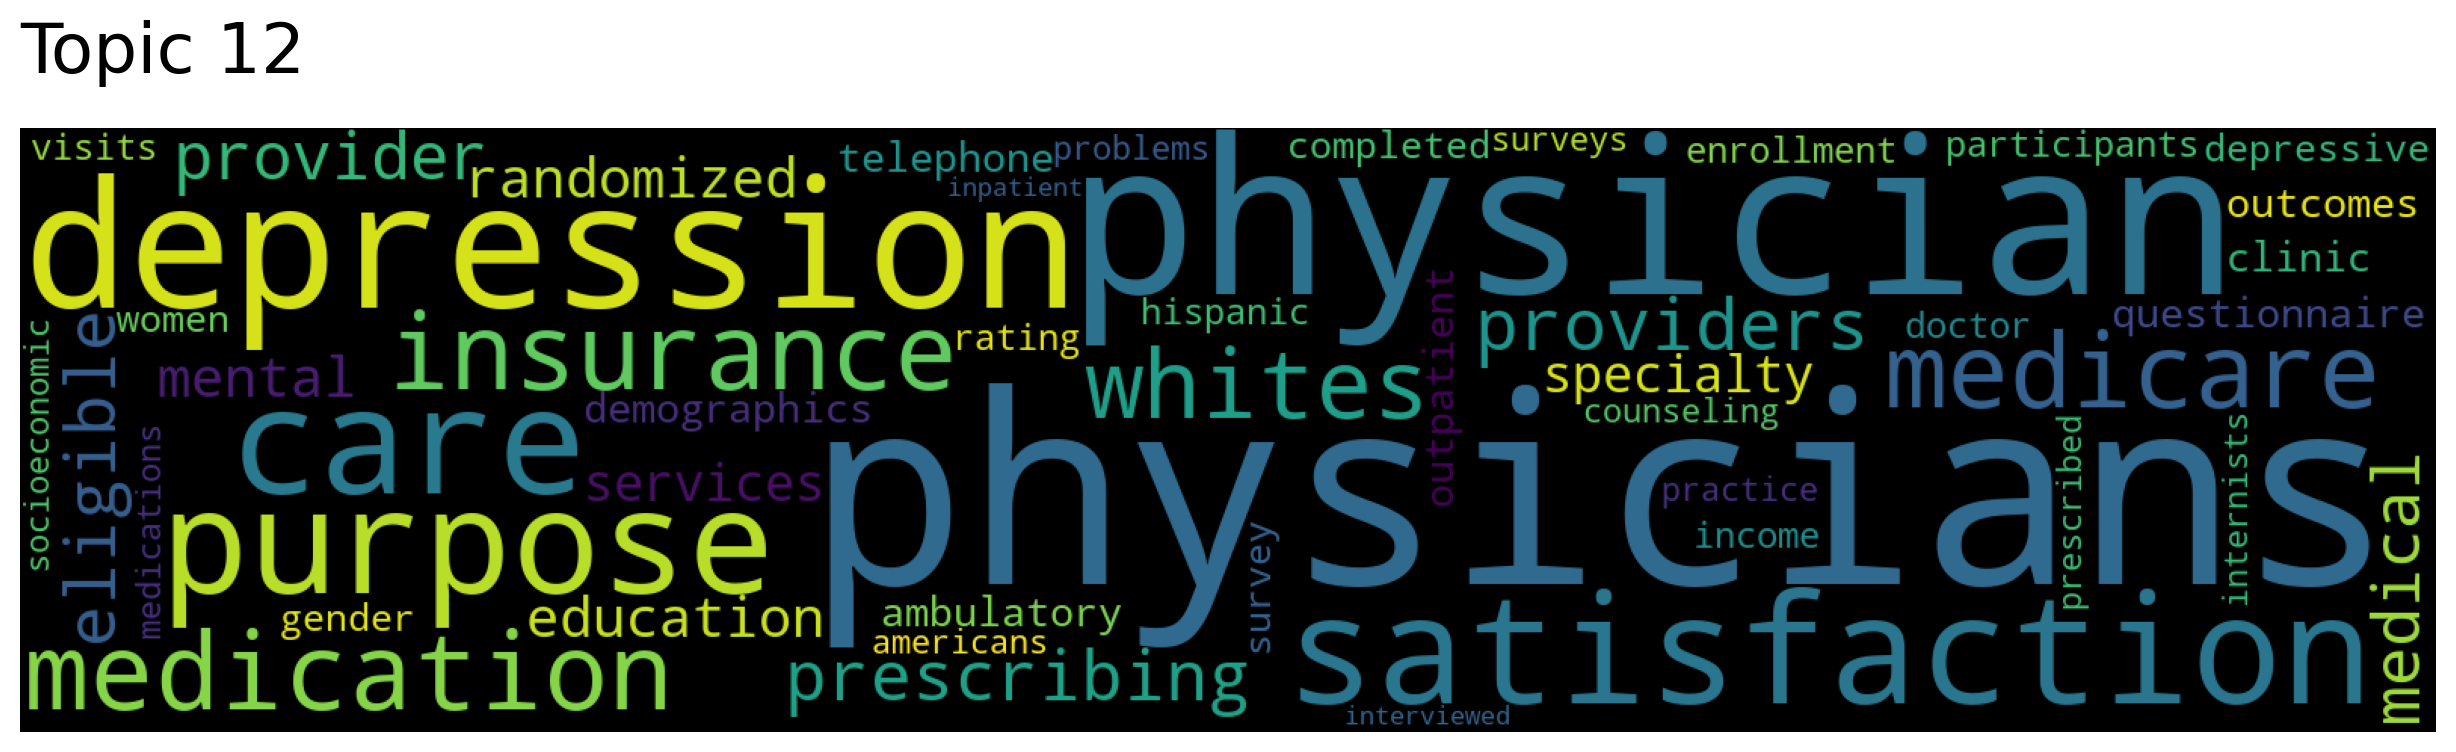

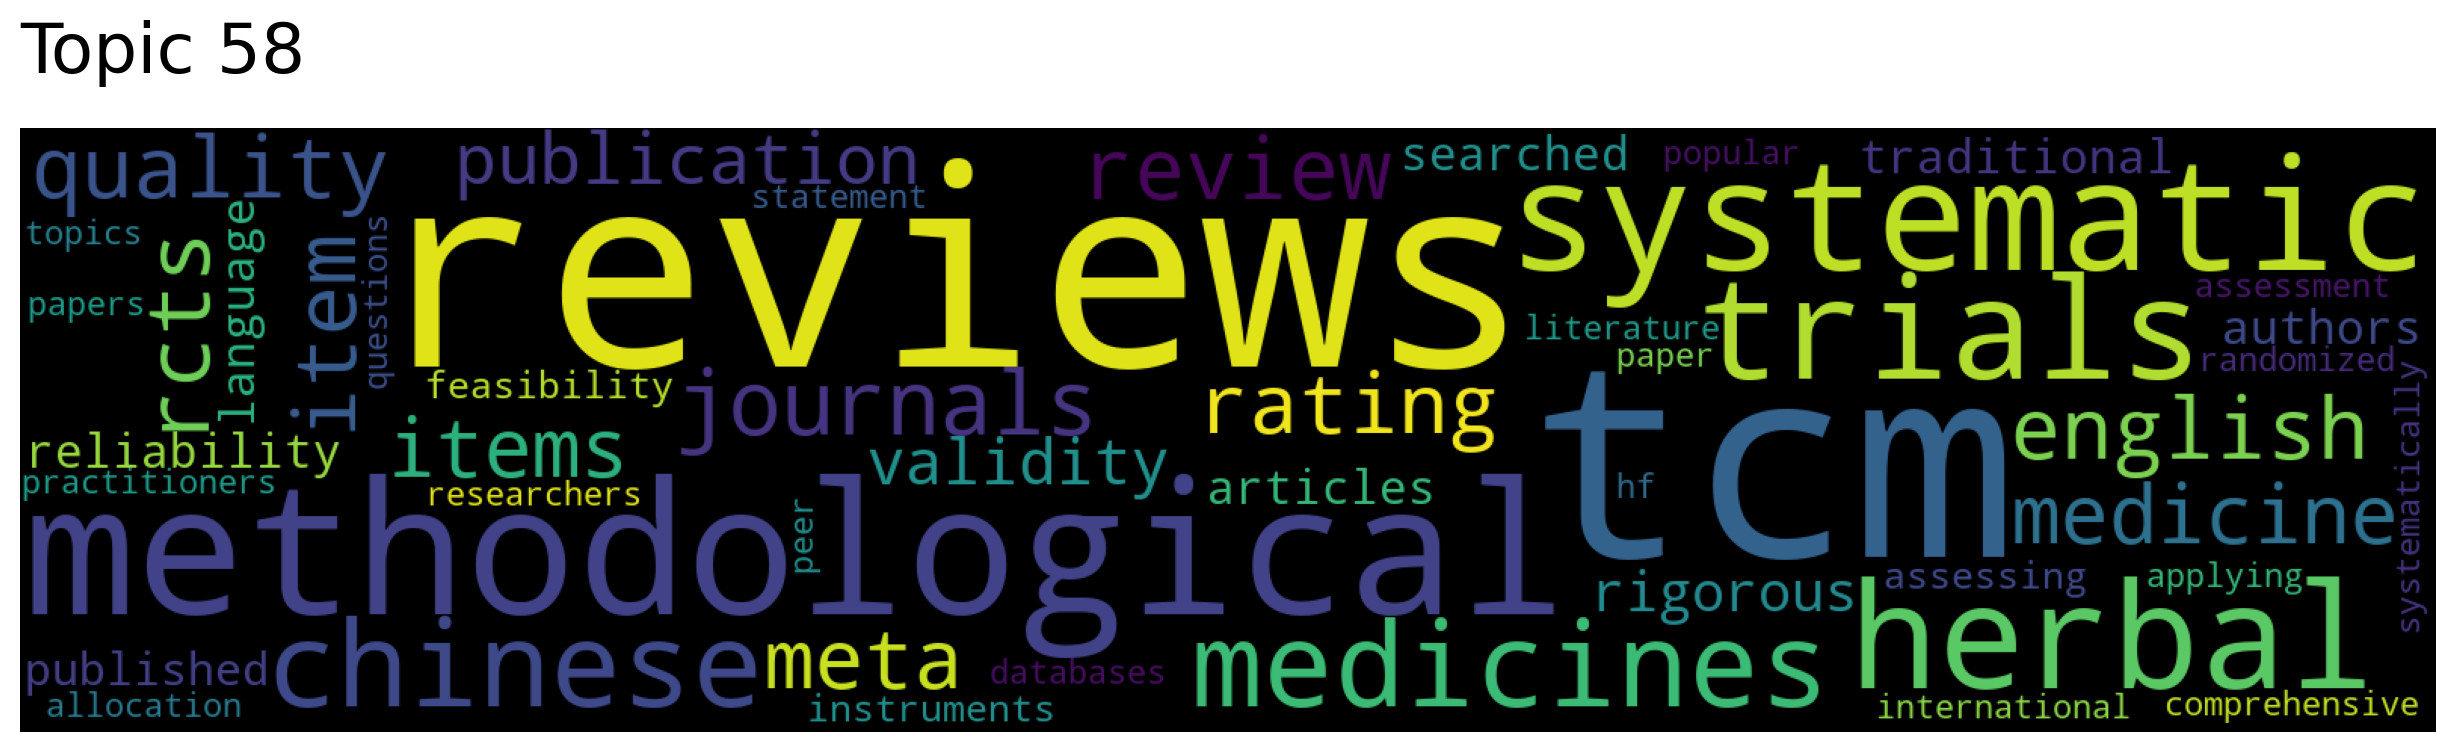

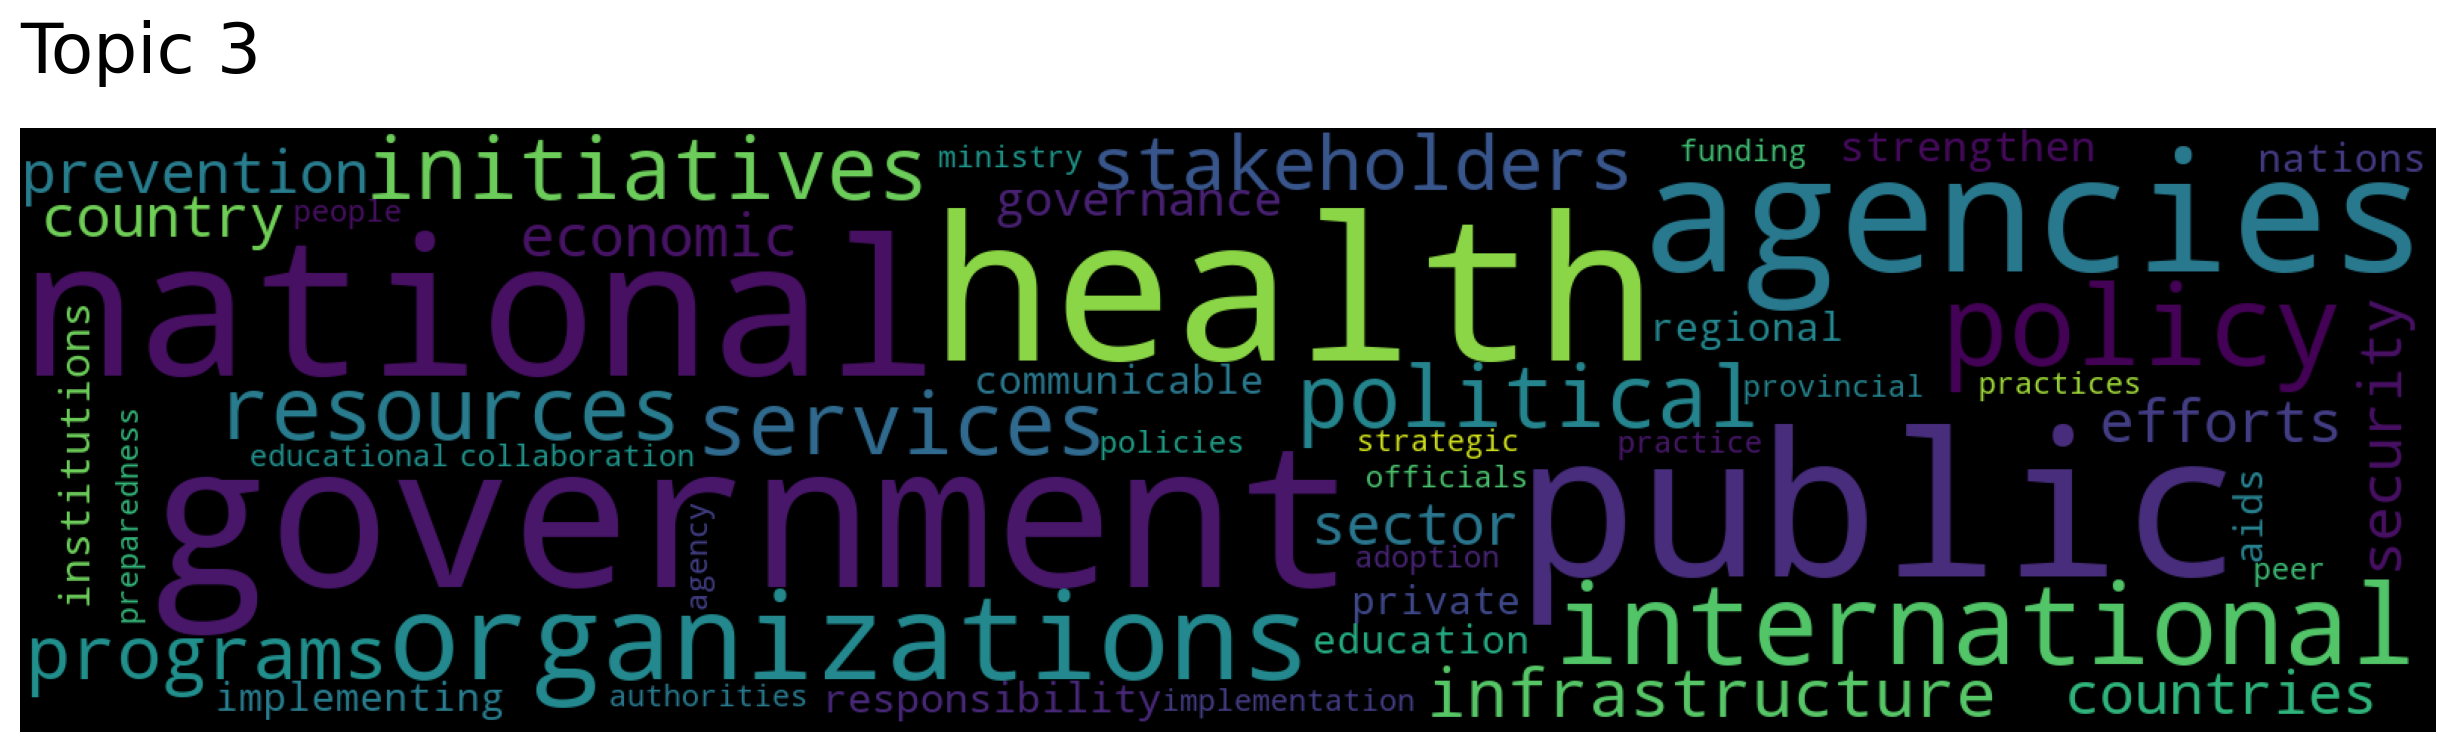

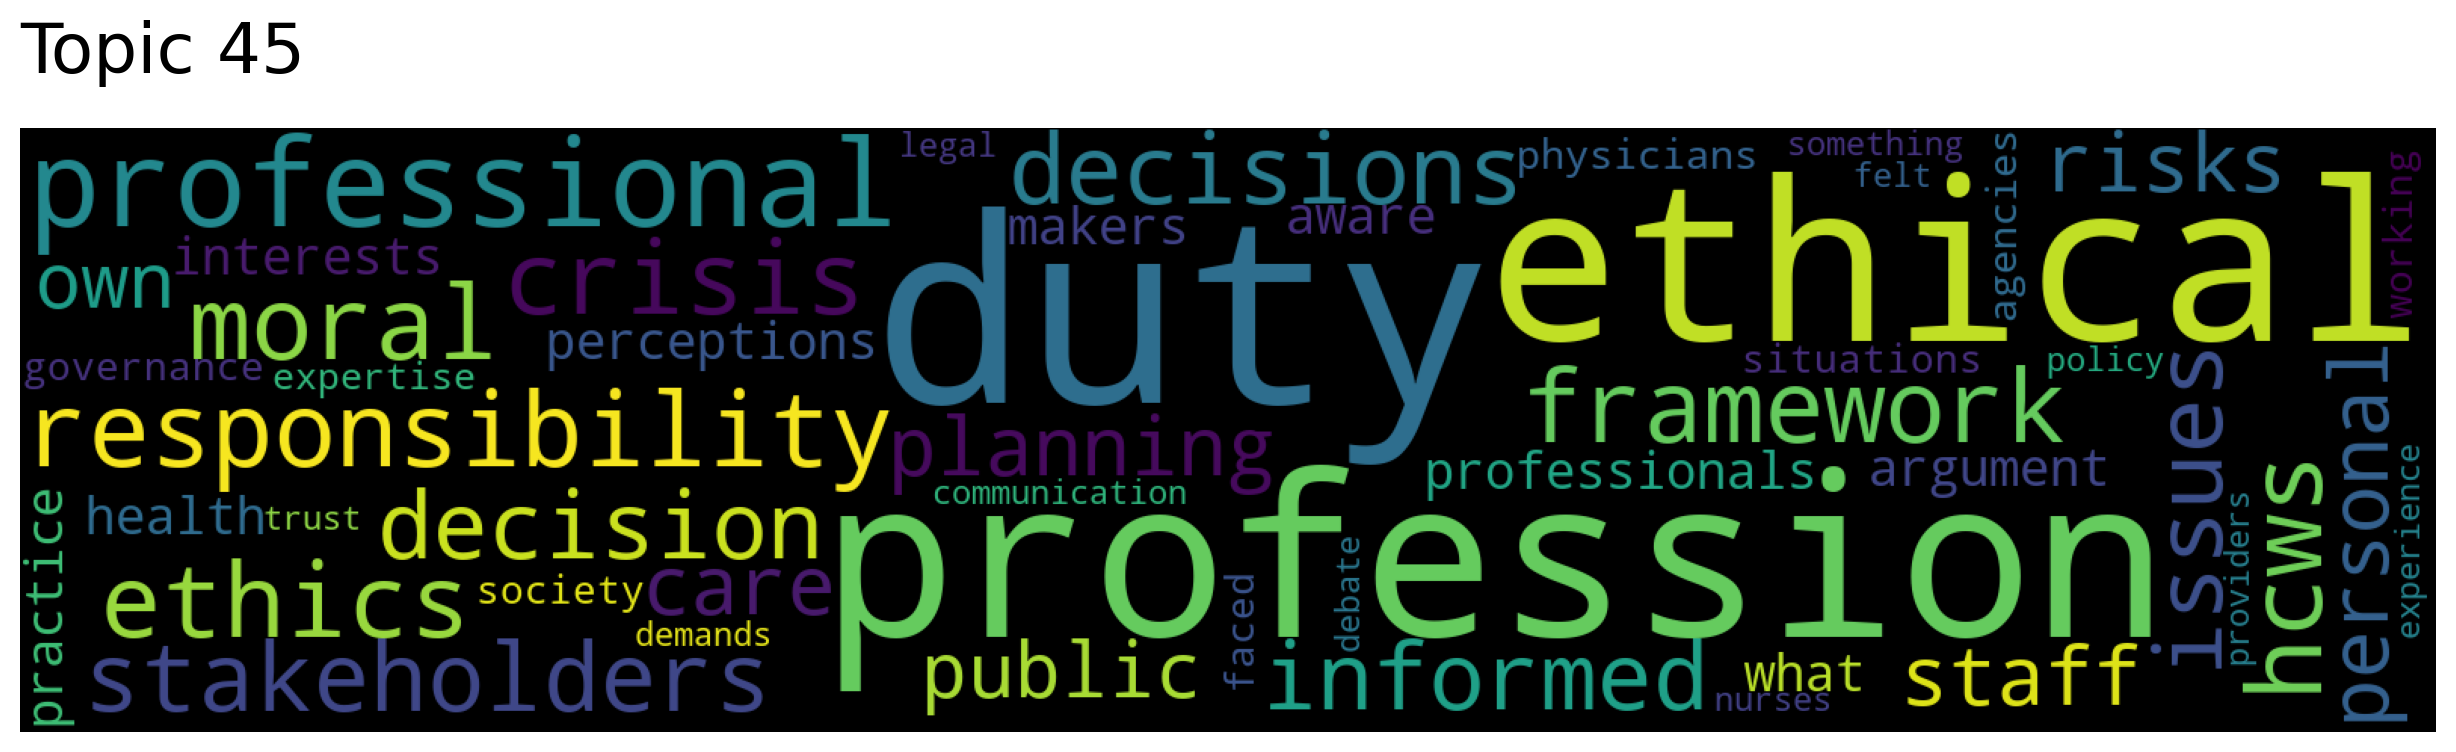

In [30]:
keywords_select_st = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_st)

keywords_input_st = widgets.Text()
display(keywords_input_st)

keywords_neg_select_st = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_st)

keywords_neg_input_st = widgets.Text()
display(keywords_neg_input_st)

doc_num_select_st = widgets.Label('Choose number of topics: ')
display(doc_num_select_st)

doc_num_input_st = widgets.Text(value='5')
display(doc_num_input_st)

def display_similar_topics(*args):
    
    clear_output()
    display(keywords_select_st)
    display(keywords_input_st)
    display(keywords_neg_select_st)
    display(keywords_neg_input_st)
    display(doc_num_select_st)
    display(doc_num_input_st)
    display(keyword_btn_st)
    
    try:
        topic_words, word_scores, topic_scores, topic_nums = top2vec.search_topics(keywords=keywords_input_st.value.split(),num_topics=int(doc_num_input_st.value), keywords_neg=keywords_neg_input_st.value.split())
        for topic in topic_nums:
            top2vec.generate_topic_wordcloud(topic, background_color="black")
        
    except Exception as e:
        print(e)
        
keyword_btn_st = widgets.Button(description="show topics")
display(keyword_btn_st)
keyword_btn_st.on_click(display_similar_topics)

# Search Papers by Topic

In [7]:
topic_num_select = widgets.Label('Select topic number: ')
display(topic_num_select)

topic_input = widgets.Text()
display(topic_input)

doc_num_select = widgets.Label('Choose number of documents: ')
display(doc_num_select)

doc_num_input = widgets.Text(value='10')
display(doc_num_input)

def display_topics(*args):
    
    clear_output()
    display(topic_num_select)
    display(topic_input)
    display(doc_num_select)
    display(doc_num_input)
    display(topic_btn)

    documents, document_scores, document_nums = top2vec.search_documents_by_topic(topic_num=int(topic_input.value), num_docs=int(doc_num_input.value))
    
    result_df = papers_df.loc[document_nums]
    result_df["document_scores"] = document_scores
    
    for index,row in result_df.iterrows():
        print(f"Document: {index}, Score: {row.document_scores}")
        print(f"Section: {row.section}")
        print(f"Title: {row.title}")
        print("-----------")
        print(row.text)
        print("-----------")
        print()

topic_btn = widgets.Button(description="show documents")
display(topic_btn)
topic_btn.on_click(display_topics)

Label(value='Select topic number: ')

Text(value='12')

Label(value='Choose number of documents: ')

Text(value='2')

Button(description='show documents', style=ButtonStyle())

Document: 6880, Score: 0.5840953588485718
Section: Rates of Depression by
Title: Society of General Internal Medicine ABSTRACTS CLINICAL VIGNETTES SUCCESSFUL TREATMENT OF RECURRENT LEUKOCYTOCLASTIC VASCULITIS WITH CELOCOXIB IN A CYSTIC FIBROSIS PATIENT
-----------
ALPHA BLOCKERS AND HYPERTENSION Ð HOW MANY ARE AT RISK FOR SUBOPTIMAL THERAPY? C.L. Bryson 1 ; 1 Puget Sound VA, Seattle, Washington PURPOSE: This study defines the number of people at risk for suboptimal therapy with hypertension who are only on alpha blockers. Results of randomized controlled trials have provided substantial evidence that antihypertensives differ in their ability to mitigate outcomes of CHF, CVA, MI and renal failure in the hypertensive population despite nearly equivalent blood pressure control. This is of particular interest because of the early termination of one arm of the ALLHAT study in which the alpha-1 blocker doxazosin was associated with a doubling of the rate of incident heart failure. Doxazosin 

# Find Similar Words¶

In [37]:
keywords_select_sw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_sw)

keywords_input_sw = widgets.Text()
display(keywords_input_sw)

keywords_neg_select_sw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_sw)

keywords_neg_input_sw = widgets.Text()
display(keywords_neg_input_sw)


doc_num_select_sw = widgets.Label('Choose number of words: ')
display(doc_num_select_sw)

doc_num_input_sw = widgets.Text(value='20')
display(doc_num_input_sw)

def display_similar_words(*args):
    
    clear_output()
    display(keywords_select_sw)
    display(keywords_input_sw)
    display(keywords_neg_select_sw)
    display(keywords_neg_input_sw)
    display(doc_num_select_sw)
    display(doc_num_input_sw)
    display(sim_word_btn_sw)
    
    try:            
        words, word_scores = top2vec.similar_words(keywords=keywords_input_sw.value.split(), keywords_neg=keywords_neg_input_sw.value.split(), num_words=int(doc_num_input_sw.value))
        for word, score in zip(words, word_scores):
            print(f"{word} {score}")
   
    except Exception as e:
        print(e)
        
sim_word_btn_sw = widgets.Button(description="show similar words")
display(sim_word_btn_sw)
sim_word_btn_sw.on_click(display_similar_words)

Label(value='Enter keywords seperated by space: ')

Text(value='patients')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of words: ')

Text(value='10')

Button(description='show similar words', style=ButtonStyle())

therapy 0.6832
patient 0.6697
who 0.6597
treatment 0.6401
enrolled 0.6075
clinical 0.605
years 0.6043
diagnosed 0.5951
months 0.5939
failure 0.5902
